# Main advantages of Hierarchical Clustering:
- Do not have to assume any particular number of clusters, any desired number of clusters can be obtained cuttin the endogram
- They may correspond to meaningful taxonomies: gerarchical classification of objects

## Two main types
1) Agglomerative: start with each poin as indivudual clustes and merge clustest while we have k clusters
2) Divisive: start with all-inclusive cluster and split while we have k clustes

In both cases we have to choose a distance measure and split/merge one cluster at a time, selecting the two clusters that have the minumum distance

## Inter-Cluster Distane
- MIN (single link): closest points in the two clusters
    - take strongly into account the contiguity so it can handle globular shapes but it is sentitive to noise
- MAX (complete link): farther points in the two clusters
    - less subsceptible to noise but tends to break large clusters and is biased towards globular ones
- Group average: mean of all possible distances between the point of the two clusters
    - good compromise between single and complete link, still a bit biased toward globular clusters
- Distance between centroids: distance between the centroids of the two clusters
- Ward's Method: the similarity between two clusters is based on the increase in squared error when the two are merged 

In [36]:
from scipy.stats import mode
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plot
import clustering_utils

In [37]:
original_df = pd.read_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv")

As a first step, since we will work on numerical features we remove categorical/nominal? attributes 

In [39]:
df = original_df[[
#    "user_id"  ,
#    "name"  ,
#    "lang"  ,
#    "bot"  ,
#    "created_at" ,
    "statuses_count" ,
    "account_age_in_days" ,
    "number_of_tweets" ,
    "account_average_tweets_per_day" ,
    "avg_tweets_per_actual_day" ,
#    "day_with_most_tweets" ,
    "max_number_of_tweets_in_a_day",
    "entropy_for_day",
    "entropy_for_hour",
    "entropy_for_minute",
    "avg_hashtags",
    "avg_text_length",
    "avg_mentions",
    "avg_special_char_in_text",
    "total_likes",
    "avt_favorite_count",
    "total_replies",
    "avt_reply_count",
    "total_retweet_count",
    "account_discussion_creation_ratio",
    "tweet_num_likes_ratio",
    "tweet_num_replies_ratio",
    "entropy_original_text",
    "entropy_text",
    "mean_inactive_period_length_in_seconds",
    "median_inactive_period_length_in_seconds",
    "mode_inactive_period_length_in_seconds",
    "mode_count"
]]

The next step is to remove the high correlated attributes and normalize the attributes to avoid bias given by the different range

In [4]:
df = clustering_utils.apply_correlation_threshold(df, "spearman", 0.7)
transformed_array = StandardScaler().fit_transform(df.values)
transformed_array.shape

(11109, 17)

In the following lines we calculate the distace between all pairs of points and then we plot the dendrogram using all the main types of inter-cluster distances

In [5]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

#Pairwise distances between observations in n-dimensional space.
data_dist = pdist(transformed_array, metric='euclidean')

single


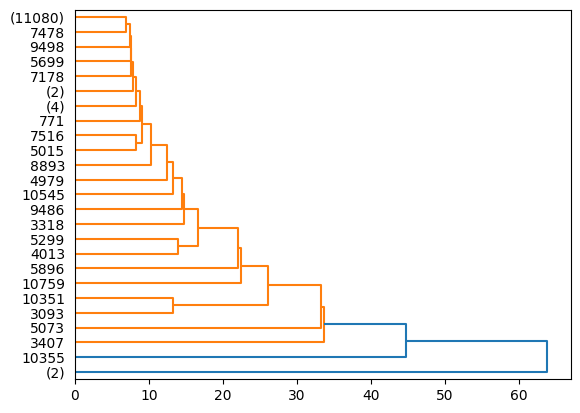

complete


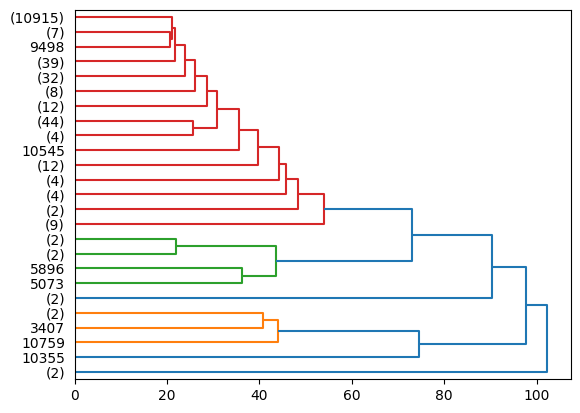

average


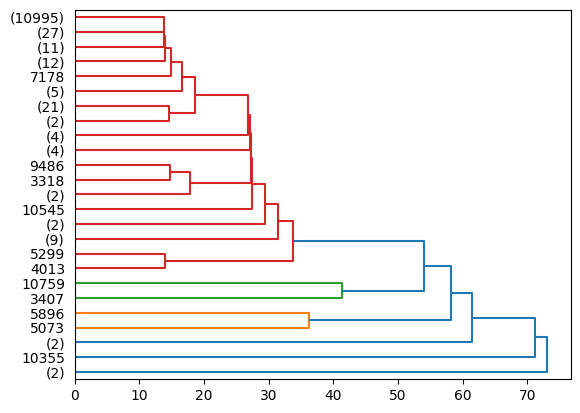

weighted


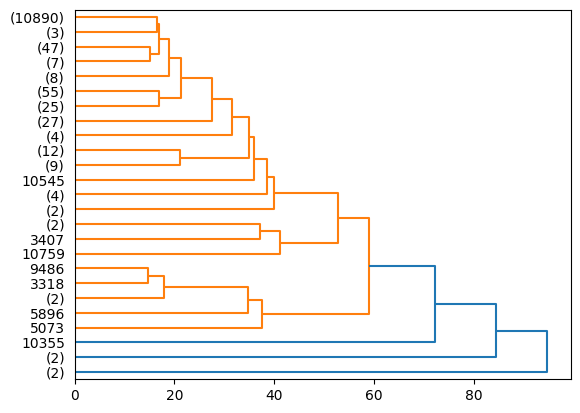

centroid


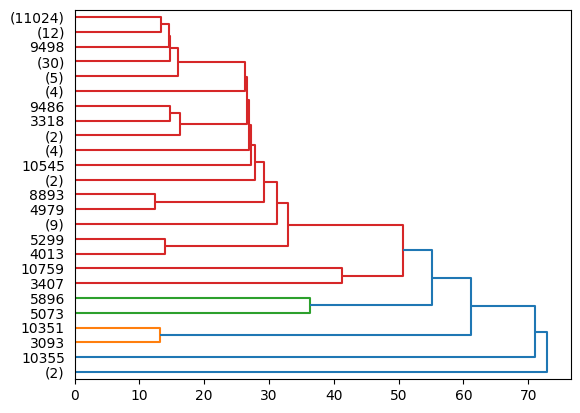

median


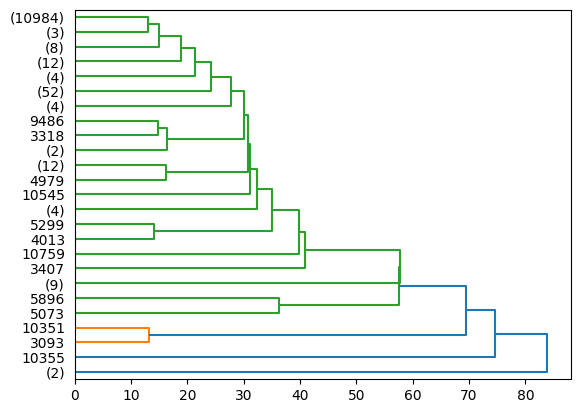

ward


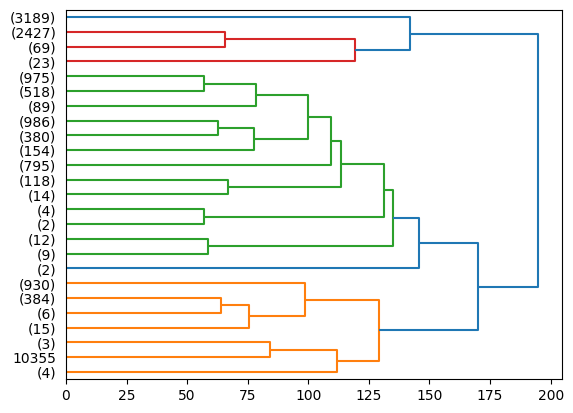

In [7]:
methods = [ 
"single",   #not working with single 
"complete", 
"average", 
"weighted", 
"centroid", 
"median", 
"ward"
] 

for method in methods:
    print(method)
    # Perform hierarchical/agglomerative clustering.    
    data_link = linkage(data_dist, method=method)
    # Plot the hierarchical clustering as a dendrogram.
    res = dendrogram(
        data_link,
        truncate_mode="lastp",
        p=25,
        orientation="right",
        show_leaf_counts=True,
        count_sort="ascending"
        )
    plt.show()

On the left of each figure you can see 25 labels, when the number has parenthesis the number is the number of point in the cluster, otherwise it means that the cluster has only one point and the number rapresent the index.
We decided to fix the number of cluster to visualize at K = 25 because we think this number is already enough if you want to distinguish different types of users or bots.
In any case, further analysis with up to 200 cluster are performed afterwards. 

The main problem that we see with almost all inter-clusters distances seems to be that the cardinality is highly unbalanced. In particular with the single link we can see that almost all the data are in a single cluster when K=25, and all other clusters (with less than 5 elements) are really near with except of few outliers. A similar, but slightly more balanced situation appears with all others metrics, except for the ward distance.
Before going on, we have to say that even with a nonsense number of clusters (like K=100), the majority of the observations are in a single one.

With the Ward distance thigs seem to be extremely different, the clusters are well balanced and the distance between them is high, we caontinue the investigation using this measure

For further investigations, in the next script we are going to compute the SSE for each possible clusteing from 2 to 200,
we expect that increasing K the decreasing of the SSE starts to become slow (the first derivative of the function going near to zero)

SSE with 2 clusters: 181.3554865907316 * 10^4
SSE with 3 clusters: 174.47513798279428 * 10^4
SSE with 4 clusters: 171.89475588673443 * 10^4
SSE with 5 clusters: 168.57344586229576 * 10^4
SSE with 6 clusters: 168.05455650628733 * 10^4
SSE with 7 clusters: 167.00380098600147 * 10^4
SSE with 8 clusters: 166.35288569872952 * 10^4
SSE with 9 clusters: 161.76246300871915 * 10^4
SSE with 10 clusters: 161.30064888566957 * 10^4
SSE with 11 clusters: 161.11573236802084 * 10^4
SSE with 12 clusters: 160.98328031259481 * 10^4
SSE with 13 clusters: 159.17170437206798 * 10^4
SSE with 14 clusters: 159.0505574213822 * 10^4
SSE with 15 clusters: 158.85346263225966 * 10^4
SSE with 16 clusters: 158.7324083586082 * 10^4
SSE with 17 clusters: 158.6908734365657 * 10^4
SSE with 18 clusters: 158.5590654837101 * 10^4
SSE with 19 clusters: 158.50867115065904 * 10^4
SSE with 20 clusters: 158.4569344946076 * 10^4
SSE with 21 clusters: 158.29534978730382 * 10^4
SSE with 22 clusters: 158.25518179454667 * 10^4
SSE wi

<AxesSubplot:xlabel='K', ylabel='SSE'>

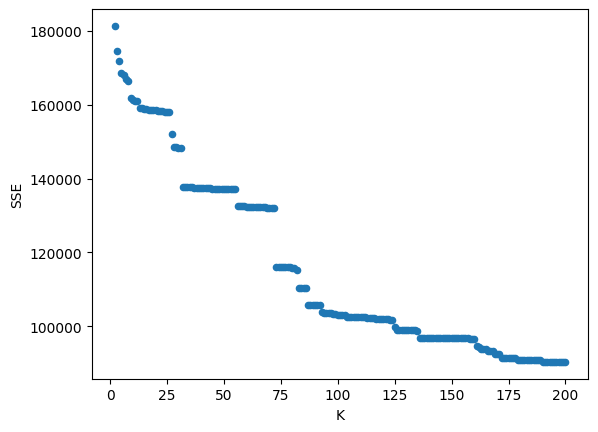

In [8]:
from sklearn.cluster import AgglomerativeClustering

min_clusters = 2 #min number of clusters to try
max_clusters = 200 #max number of clusters to try

sse_df = pd.DataFrame(columns=["K", "SSE"])
for num_curr_clusters in range(2, max_clusters+1): # try differen number of clusters
    #compute the cluster
    labels = AgglomerativeClustering(n_clusters = num_curr_clusters, affinity='euclidean', linkage='ward').fit_predict(df)
    #print("trying with", num_curr_clusters, "clusters")
    global_sse = 0 #the sse for the clustering with this number of clusters

    for i in range(num_curr_clusters): # for each cluster
        indexes = np.nonzero(labels==i)[0] # indexes where the label is equal to the current cluster 
        points_in_cluster = np.take(transformed_array, indexes, axis=0 ) # points in the cluster
        #print("in the cluster", i, "there are ", points_in_cluster.shape, "points")
        centroid = np.mean(points_in_cluster, axis=0)

        # calculate the sse for the single cluster
        current_sse = 0
        for p in points_in_cluster:
            current_sse += np.square( np.linalg.norm( np.subtract(p, centroid)))

        global_sse += current_sse
        
    sse_df = pd.concat( [sse_df , pd.DataFrame({"K" : [num_curr_clusters], "SSE": [global_sse] }) ], axis=0)
    print("SSE with", num_curr_clusters, "clusters:", global_sse / 1000, "* 10^4")

sse_df = sse_df.astype({"K" : int , "SSE" : float})
sse_df.plot.scatter(x = "K", y="SSE")

The biggest SSE decreasing is between 0 and 100. From 100 to 200 the SSE of course still decreases but slower compered to the number of cluster added.

The clustering theory suggests to set 75< K <100 the problem with this number is that, again, a lot of clusters have few elements i.e. 50% of clusters have less than 8 observations and 75% of clusters have less than 40 observations, as shown below.

In [44]:
from sklearn.cluster import AgglomerativeClustering
K = 10


def clustering_stats(observations: pd.DataFrame, original_df:pd.DataFrame, K : int) -> pd.DataFrame:
    cluster = AgglomerativeClustering(n_clusters = K, affinity='euclidean', linkage='ward')
    labels = cluster.fit_predict(observations)

    sizes = [len(np.nonzero(labels==i)[0]) for i in range(K)]
    
    bot_percentage = []

    for i in range(K):
        indexes_of_this_cluster = np.nonzero(labels==i)[0]
        indexes_of_this_cluster = [i for i in indexes_of_this_cluster]
        cluster_df = original_df.iloc[indexes_of_this_cluster]
        bot_df = cluster_df[cluster_df["bot"] == 1]
        bot_percentage.append( len(bot_df.index)/sizes[i] )
    
    return pd.DataFrame({ 
        "cluster_size" : sizes ,
        "bot_percentage" : bot_percentage
    })

clustering_stats(df,original_df, K)

,cluster_size,bot_percentage
0,12,0.916667
1,33,0.666667
2,164,0.030488
3,10559,0.556208
4,26,0.000000
5,8,0.875000
6,45,0.644444
7,6,0.666667
8,252,0.654762
9,4,0.000000


#TODO continue the discussion, why below are unbalanced while in the dendogram with ward and p=25 are balanced?

In [48]:
clustering_stats(df,original_df,  25)

,cluster_size,bot_percentage
0,4,0.000000
1,8870,0.591883
2,8,0.875000
3,6,0.666667
4,13,0.615385
5,163,0.619632
6,10,0.900000
7,32,0.656250
8,6,0.500000
9,459,0.006536


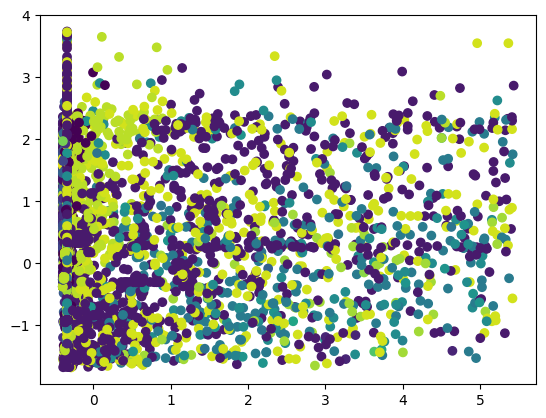

In [24]:
plt.scatter(transformed_array[:,0],transformed_array[:,1], c=labels)